# Recurrent Neural Network - Predict Stock Market with Finance Data and News Data
The source of inspiration was this blog post: 
https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8

This is the basis for training the neural network. 

# Import necesary libraries

In [11]:
import numpy as np
import time as tm
import datetime as dt
from array import array


from math import sqrt

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from collections import deque

import pandas as pd
from pandas import DataFrame
from pandas import concat

# AI
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Graphics library
import matplotlib.pyplot as plt


# Settings

In [3]:
# Set the parametes need for the RNN

# Stock ticker, TSLA. Here we will get the stick ticker the others too.
STOCK = 'TSLA'

# Load Data

In [4]:
import duckdb
import os

class PredictionInputRepository:
    def __init__(self, csv_file_path=None):
        self.connection = duckdb.connect(database=':memory:', read_only=False)
        if os.path.isfile(f'{csv_file_path}/prediction_input.csv'):
            try:
                self.connection.execute(f"IMPORT DATABASE '{csv_file_path}';")
            except Exception as e:
                self._create_table()
                self.connection.execute(f"EXPORT DATABASE '{csv_file_path}';")
        else:
            self._create_table()

    def _create_table(self):
        self.connection.execute("CREATE TABLE prediction_input (id VARCHAR UNIQUE, articleId INTEGER UNIQUE, timestamp VARCHAR, close DOUBLE, relevance DOUBLE, sentimentPositive DOUBLE, sentimentNegative DOUBLE, sentimentNeutral DOUBLE)")
        self.connection.execute("CREATE SEQUENCE id_sequence START 1 INCREMENT BY 1;")

    def insert(self, prediction_input):
        self.connection.execute("PREPARE insert_prediction_input AS "
                                "INSERT INTO prediction_input VALUES (nextval('id_sequence'), ?, ?, ?, ?, ?, ?, ?) ON CONFLICT DO NOTHING;")
        self.connection.execute(f"EXECUTE insert_prediction_input('{prediction_input['articleId']}', '{prediction_input['timestamp']}', {prediction_input['close']}, {prediction_input['relevance']}, {prediction_input['sentimentPositive']}, {prediction_input['sentimentNegative']}, {prediction_input['sentimentNeutral']});")

    def select_all(self):
        return self.connection.execute("SELECT * FROM prediction_input").fetchdf()

    def select_by_date(self, date_from, date_to):
        return self.connection.execute(f"SELECT * FROM prediction_input WHERE strptime(timestamp, '%Y-%m-%dT%H:%M:%S%z') BETWEEN strptime('{date_from}','%Y-%m-%d') AND strptime('{date_to}','%Y-%m-%d')").fetchdf()
    
    def select_by_date_order(self, date_format = '%Y-%m-%dT%H:%M:%S%z'):
        return self.connection.execute(f"SELECT * FROM prediction_input ORDER BY strptime(timestamp, '{date_format}') DESC").fetchdf()

    def export(self, csv_file):
        self.connection.execute(f"EXPORT DATABASE '{csv_file}';")


# Prepare Prediction Input

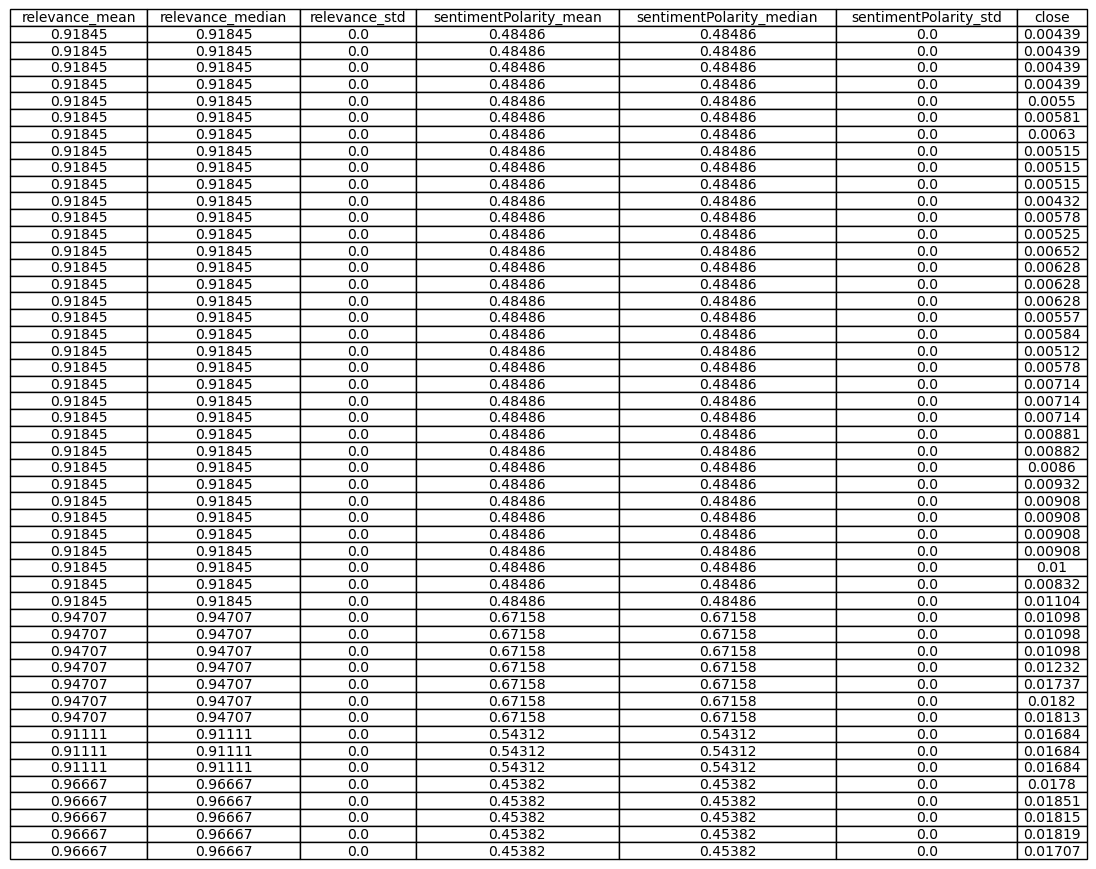

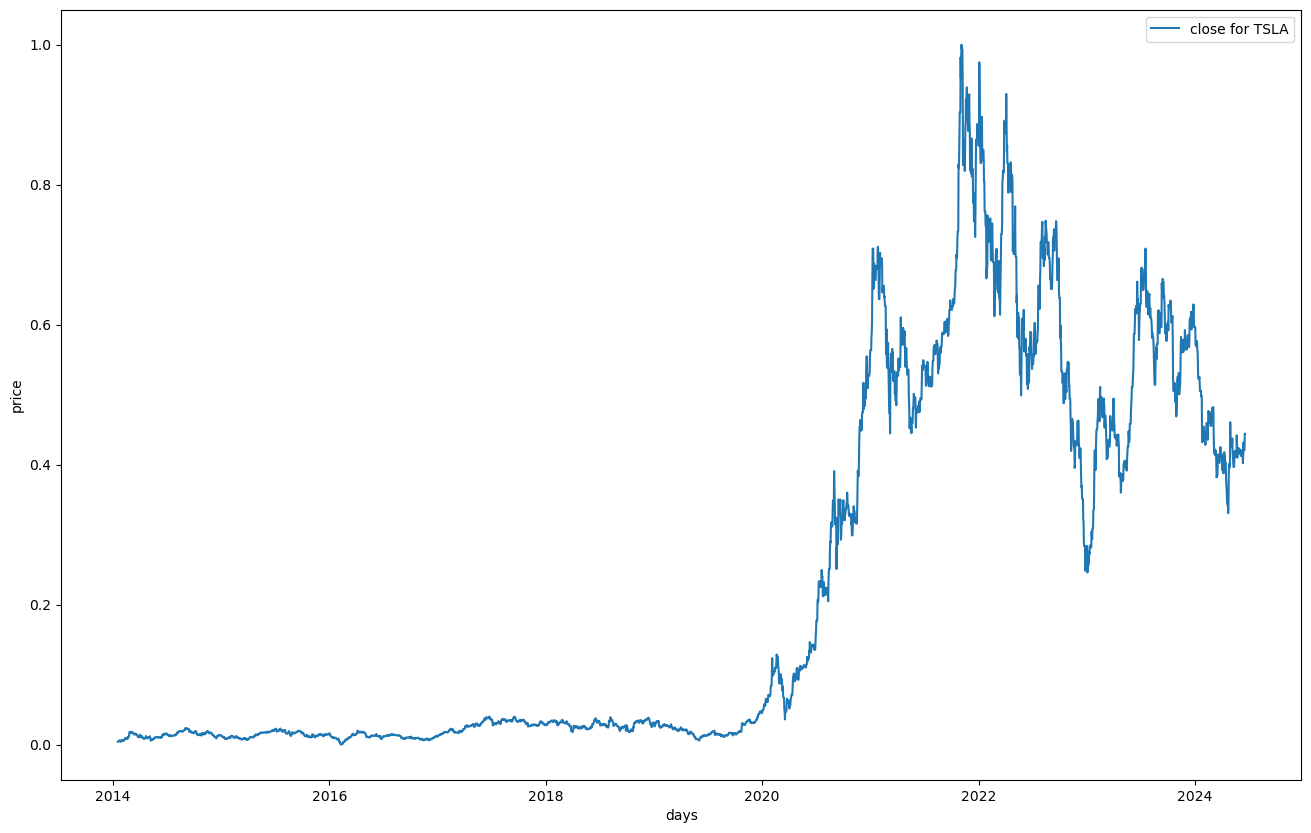

In [91]:
def prepare_prediction_input(source):
    prediction_input_repo = PredictionInputRepository(f"prediction_input/{source}")

    if source == "bbc":
        return prediction_input_repo.select_by_date_order("%Y-%m-%dT%H:%M:%S.%fZ")
    else:
        return prediction_input_repo.select_by_date_order()

# input as df
def show_prediction_input_table(prediction_input):
    most_ten_input_data = prediction_input.head(50)
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    table = plt.table(cellText=most_ten_input_data.values, colLabels=most_ten_input_data.columns, cellLoc = 'center', loc='center')
    table.auto_set_column_width(col=list(range(len(most_ten_input_data.columns))))
    plt.show()
    
def plot_graph(input_df, column_name):
    plt.figure(figsize=(16,10))
    plt.plot(input_df[column_name])
    plt.xlabel("days")
    plt.ylabel("price")
    plt.legend([f'{column_name} for {STOCK}'])
    plt.show()

def calculate_sentiment_polarity(rows):
    rows["sentimentPolarity"] = round(rows['sentimentPositive'] - rows['sentimentNegative'],5)
    rows["sentimentPolarity"] = np.interp(rows["sentimentPolarity"], (-1, 1), (0, 1)) if rows["relevance"] > 0 else 0
    rows = rows.drop(['sentimentPositive', 'sentimentNegative', 'sentimentNeutral'])
    return rows

def calculate_sentiment_statistics_per_day(input):
    input["timestamp"] = input["timestamp"].apply(lambda x: x.split("T")[0])
    input_temp = input.drop(input[input.relevance <= 0].index)
    input_temp = input_temp.groupby(["timestamp"], as_index=False).agg({"relevance": ["mean", "median", "std"], "sentimentPolarity": ["mean", "median", "std"]})
    
    input_temp.columns = [("_".join(x) if x[1] != "" else x[0]) for x in input_temp.columns.ravel()]

    return input_temp

def forward_fill_missing_dates_values(input_df):
    input_df["timestamp"] = pd.to_datetime(input_df["timestamp"])
    input_df = input_df.set_index("timestamp")
    input_df = input_df.resample("D").ffill().reset_index()
    return input_df

def add_close_price_per_date(input_df):    
    min_date = str(input_df["timestamp"].min()).split(" ")[0]
    max_date = str(input_df["timestamp"].max()).split(" ")[0]
    
    stock_df = yf.get_data(
        STOCK,
        start_date=min_date,
        end_date=max_date,
        interval='1d')
    stock_df = stock_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
    stock_df['date'] = stock_df.index
    
    input_df = pd.merge(input_df, stock_df, left_on="timestamp", right_on="date", how="left").drop("date", axis=1)
    
    return input_df

def fill_missing_close_price_values(input_df):
    input_df["close"] = input_df["close"].ffill().bfill()
    return input_df

def fill_missing_standard_deviation(input_df):
    input_df["relevance_std"] = input_df["relevance_std"].fillna(0)
    input_df["sentimentPolarity_std"] = input_df["sentimentPolarity_std"].fillna(0)
    return input_df

def round_values(input_df):
    input_df = input_df.round(5)
    return input_df

def transform_close_price_min_max(input_df):
    input_df["close"] = input_df["close"].apply(lambda x: np.interp(x, (input_df["close"].min(), input_df["close"].max()), (0, 1)))
    return input_df

def get_processed_dataframe_prediction_input(source):
    input_df = prepare_prediction_input(source).drop("close", axis=1)
    input_df = input_df.apply(calculate_sentiment_polarity, axis=1)
    input_df = calculate_sentiment_statistics_per_day(input_df)
    input_df = forward_fill_missing_dates_values(input_df)
    input_df = add_close_price_per_date(input_df)
    input_df = fill_missing_close_price_values(input_df)
    input_df = fill_missing_standard_deviation(input_df)
    input_df = transform_close_price_min_max(input_df)
    input_df = round_values(input_df)
    input_df.set_index("timestamp", inplace=True)
    return input_df

ft_input_df = get_processed_dataframe_prediction_input("ft")

show_prediction_input_table(ft_input_df)
plot_graph(ft_input_df, "close")

# Transform multivariate time series to supervised learning input

This part relies on this blog post: 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [135]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def prepare_multivariate_input_data(input_df):
    # load dataset
    dataset = input_df.copy()
    values = dataset.values
    # frame as supervised learning
    reframed = series_to_supervised(values, 1, 1)
    # drop columns we don't want to predict
    # reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
    return reframed

# ft_mv_input_df = prepare_multivariate_input_data(ft_input_df.drop(["sentimentPolarity_mean", "sentimentPolarity_median", "sentimentPolarity_std"], axis=1))
print(ft_mv_input_df.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t)  var2(t)  var3(t)  \
1    0.91845    0.91845        0.0    0.00439  0.91845  0.91845      0.0   
2    0.91845    0.91845        0.0    0.00439  0.91845  0.91845      0.0   
3    0.91845    0.91845        0.0    0.00439  0.91845  0.91845      0.0   
4    0.91845    0.91845        0.0    0.00439  0.91845  0.91845      0.0   
5    0.91845    0.91845        0.0    0.00550  0.91845  0.91845      0.0   

   var4(t)  
1  0.00439  
2  0.00439  
3  0.00439  
4  0.00550  
5  0.00581  


# Split the data into training and test data

In [136]:
def get_train_test_data(input_df):
    split_ratio = 0.85
    
    # Calculate the split index
    split_index = int(len(input_df) * split_ratio)

    # Split the DataFrame into training and testing sets
    train_df = input_df[:split_index]
    test_df = input_df[split_index:]

    # Split into input features (X) and target variable (y)
    train_X, train_y = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
    test_X, test_y = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, test_X, test_y

look_back = 15

train_X, train_y, test_X, test_y = get_train_test_data(ft_mv_input_df)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(3234, 1, 7) (3234,) (571, 1, 7) (571,)


# Create the two-layer LSTM model

Epoch 1/100


/Users/sebastiantatar/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1610 - val_loss: 0.4120
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1230 - val_loss: 0.0295
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.0256
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0153
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0159
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0174
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_lo

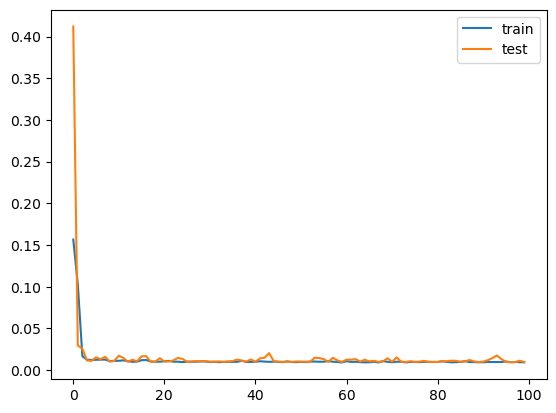

In [137]:
def create_model(train_X):
    model = Sequential()
    model.add(LSTM(40, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model 

def fit_model(model, train_X, train_y, test_X, test_y):
    BATCH_SIZE = 72
    EPOCHS = 100
    
    # fit network
    history = model.fit(train_X, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), verbose=1)
    return history

def plot_history(fit_result):
    # plot history
    plt.plot(fit_result.history['loss'], label='train')
    plt.plot(fit_result.history['val_loss'], label='test')
    plt.legend()
    plt.show()

model = create_model(train_X)
fit_result = fit_model(model, train_X, train_y, test_X, test_y)
plot_history(fit_result)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


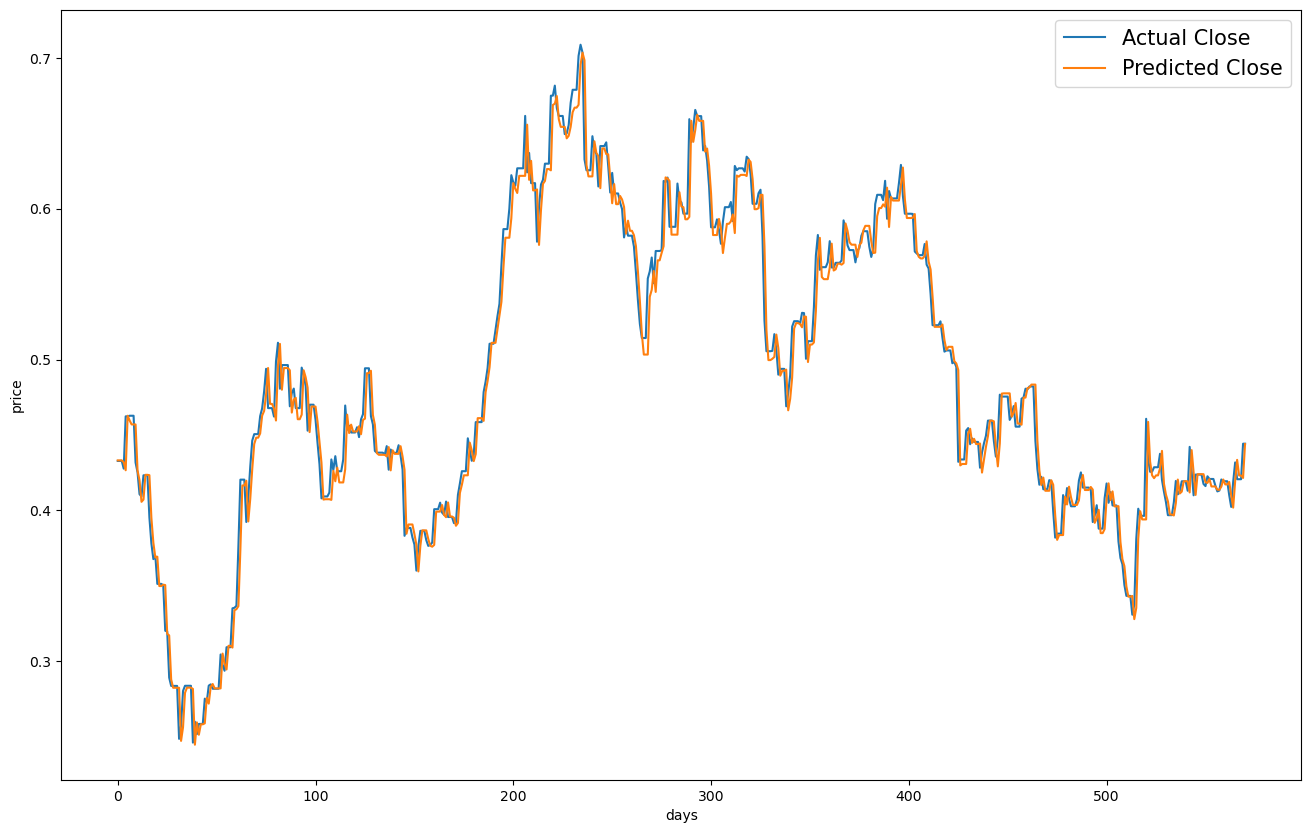

Test RMSE: 0.015 


In [149]:
# make a prediction
yhat = model.predict(test_X)
test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Concatenate the predicted values (yhat) with the other features from test_X
inv_yhat = np.concatenate((yhat, test_X_new[:, 1:]), axis=1)

# Extract the predicted "close" values
predicted_close = inv_yhat[:, 0]

plt.figure(figsize=(16,10))
# plt.plot(train_y, label='Train')
plt.plot(test_y, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.xlabel("days")
plt.ylabel("price")
plt.legend(bbox_to_anchor =(1, 1), fontsize=15)
plt.show()

rmse = sqrt(mean_squared_error(predicted_close, test_y))
print('Test RMSE: %.3f ' % rmse)